In [ ]:
import pandas as pd
import numpy as np
import os
from sklearn.metrics import (
    root_mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score,
    mean_squared_error
)


ticker_to_basename = {
    # Indices
    "^NSEI": "NIFTY_50",
    "^NSEBANK": "NIFTY_BANK",
    "^CNXIT": "NIFTY_IT",
    "^CNXPHARMA": "NIFTY_PHARMA",
    "^CNXFMCG": "NIFTY_FMCG",
    "^CNXAUTO": "NIFTY_AUTO",
    "^CNXMETAL": "NIFTY_METAL",
    "^CNXREALTY": "NIFTY_REALTY",
    "^CNXENERGY": "NIFTY_ENERGY",
    "NIFTY_FIN_SERVICE.NS": "NIFTY_FIN_SERVICE",
    
    # Stocks
    "RELIANCE.NS": "RELIANCE_INDUSTRIES_LTD",
    "TCS.NS": "TATA_CONSULTANCY_SERV_LT", # Matched from your image
    "SUNPHARMA.NS": "SUN_PHARMACEUTICAL_IND_L",
    "ICICIBANK.NS": "ICICI_BANK_LTD.",
    "INFY.NS": "INFOSYS_LIMITED",
    "SBIN.NS": "STATE_BANK_OF_INDIA",
    "BHARTIARTL.NS": "BHARTI_AIRTEL_LIMITED",
    "ITC.NS": "ITC_LTD",
    "LT.NS": "LARSEN_&_TOUBRO_LTD.",
    "HINDUNILVR.NS": "HINDUSTAN_UNILEVER_LTD."
}

all_tickers = list(ticker_to_basename.keys())


raw_data_folder = r"X:\AGDrive\ADA-Timeseries project\Raw_Data"
predicted_data_folder = r"X:\AGDrive\ADA-Timeseries project\Pred_Data"
lagging_data_folder = r"X:\AGDrive\ADA-Timeseries project\Lag_Data"

In [10]:
equity_ticker_symbol = "^CNXPHARMA"
equity = ticker_to_basename[equity_ticker_symbol]
equity

'NIFTY_PHARMA'

In [11]:
predicted_data_file = os.path.join(predicted_data_folder, f"{equity}_predictions_xgboost.csv")
predicted_data = pd.read_csv(predicted_data_file, parse_dates=['Datetime'], index_col='Datetime')

# --- Print to verify ---
print(f"Predicted File:    {predicted_data_file}")

# If 'return' column doesn't exist, create it directly
if 'return' not in predicted_data.columns:
    predicted_data['return'] = (predicted_data['PredictedPrice'] - predicted_data['ActualPrice']) / predicted_data['ActualPrice']
else:
    # Only compute for missing values
    predicted_data.loc[predicted_data['return'].isna(), 'return'] = (
        (predicted_data['PredictedPrice'] - predicted_data['ActualPrice']) / predicted_data['ActualPrice']
    )

# Save changes to same CSV
predicted_data.to_csv(predicted_data_file, index=True)
print(f"✅ Changes saved to: {predicted_data_file}")

predicted_data.tail()

Predicted File:    X:\AGDrive\ADA-Timeseries project\Pred_Data\NIFTY_PHARMA_predictions_xgboost.csv
✅ Changes saved to: X:\AGDrive\ADA-Timeseries project\Pred_Data\NIFTY_PHARMA_predictions_xgboost.csv


,ActualPrice,PredictedPrice,return
Datetime,,,
2025-11-11 11:15:00,22308.650391,22321.210938,0.000563
2025-11-11 12:15:00,22326.599609,22346.751953,0.000903
2025-11-11 13:15:00,22336.349609,22344.769531,0.000377
2025-11-11 14:15:00,22371.250000,22339.376953,-0.001425
2025-11-11 15:15:00,22374.250000,22350.929688,-0.001042


In [12]:
# Step 1: Read the predictions CSV
data = predicted_data

# Step 2: Drop rows where the predicted price is -inf
# Use a boolean mask to filter out rows where 'PredictedPrice' is negative infinity
eval_df = data[data['PredictedPrice'] != -np.inf]

# Step 3: Extract actual and predicted values
y_true = eval_df['ActualPrice'].values
y_pred = eval_df['PredictedPrice'].values

# Step 4: Calculate evaluation metrics
rmse = root_mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)

# Step 5: Mean Error (ME) calculation
# The Mean Error is the average of the differences (residuals).
mean_error = np.mean(y_pred - y_true)

# Step 6: Adjusted R² calculation
n = len(y_true)
p = len(eval_df.columns) - 1 # Exclude ActualPrice
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

# Step 7: Print all metrics
print(f"➡️ MSE: {mse:.4f}")
print(f"✅ RMSE: {rmse:.4f}")
print(f"➡️ MAE: {mae:.4f}")
print(f"➡️ MAPE: {mape:.4%}")
print(f"✅ R² Score: {r2:.4f}")
print(f"➡️ Adjusted R²: {adjusted_r2:.4f}")
print(f"➡️ Mean Error: {mean_error:.4f}")

➡️ MSE: 4198.2022
✅ RMSE: 64.7935
➡️ MAE: 46.4457
➡️ MAPE: 0.2213%
✅ R² Score: 0.9984
➡️ Adjusted R²: 0.9984
➡️ Mean Error: -7.3366


In [13]:
# from plot_data_util import plot_train_and_prediction_and_last_pred_point
# plot_train_and_prediction_and_last_pred_point(predicted_data, "NIFTY 50", n=10, last_pred=last_pred)

In [14]:
from plot_data_util import plot_train_and_prediction
plot_train_and_prediction(predicted_data, ticker=equity, n=35)

In [15]:
from plot_data_util import plot_train_and_prediction
plot_train_and_prediction(predicted_data, ticker=equity, n=100)

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

def simulate_investment(df, amt, start_date, end_date, plot=True):
    df = df.copy()

    # ✅ Ensure Datetime is a column (avoid duplication/ambiguity)
    if 'Datetime' in df.index.names:
        df = df.reset_index()

    if 'Datetime' not in df.columns:
        raise ValueError("No 'Datetime' column found after reset_index.")

    df["Datetime"] = pd.to_datetime(df["Datetime"])
    df = df.sort_values("Datetime").reset_index(drop=True)

    # ---- Filter to start/end range with flexibility ----
    actual_start = df[df["Datetime"] >= pd.to_datetime(start_date)]
    if actual_start.empty:
        raise ValueError("No data after the given start_date")
    start_row = actual_start.iloc[0]

    actual_end = df[df["Datetime"] <= pd.to_datetime(end_date)]
    if actual_end.empty:
        raise ValueError("No data before the given end_date")
    end_row = actual_end.iloc[-1]

    # Keep only data between adjusted start and end
    df = df[(df["Datetime"] >= start_row["Datetime"]) & (df["Datetime"] <= end_row["Datetime"])].reset_index(drop=True)

    # ---- Compute predicted and actual returns ----
    df["pred_return"] = df["PredictedPrice"].pct_change()
    df["actual_return"] = df["ActualPrice"].pct_change()

    invested = False
    cash = amt
    values = [cash]  # track value over time

    for i in range(1, len(df)):
        signal = df.loc[i, "pred_return"]
        actual_r = df.loc[i, "actual_return"]

        # If model predicts profit
        if signal > 0:
            if not invested:
                invested = True
            cash *= (1 + actual_r)  # update when invested
        else:
            if invested:
                invested = False  # sell
            # no growth if not invested

        values.append(cash)

    df["InvestmentValue"] = values

    # ---- Final summary ----
    final_value = df["InvestmentValue"].iloc[-1]
    profit_pct = ((final_value - amt) / amt) * 100

    summary = {
        "Initial Date Given": start_date,
        "Actual date of investment": str(start_row["Datetime"].date()),
        "Final Date Given": end_date,
        "Actual date of withdraw": str(end_row["Datetime"].date()),
        "Initial Amount": amt,
        "Final Amount": round(final_value, 2),
        "Return (%)": round(profit_pct, 2)
    }

    # ---- Plot the investment growth ----
    if plot:
        plt.figure(figsize=(10, 5))
        plt.plot(df["Datetime"], df["InvestmentValue"], label="Investment Value", linewidth=2)
        plt.scatter(df["Datetime"].iloc[0], amt, color='green', label="Start")
        plt.scatter(df["Datetime"].iloc[-1], final_value, color='red', label="End")
        plt.title("Investment Growth Over Time")
        plt.xlabel("Datetime")
        plt.ylabel("Investment Value")
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.legend()
        plt.tight_layout()
        plt.show()

    return pd.Series(summary), df[["Datetime", "InvestmentValue"]]


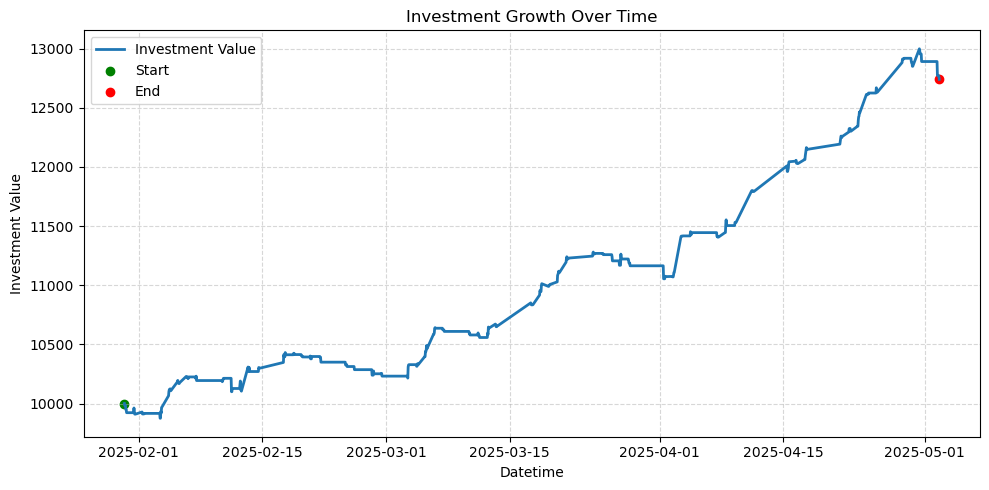

Initial Date Given           2025-01-30
Actual date of investment    2025-01-30
Final Date Given              2025-5-03
Actual date of withdraw      2025-05-02
Initial Amount                    10000
Final Amount                   12739.16
Return (%)                        27.39
dtype: object


In [17]:
summary, curve = simulate_investment(predicted_data, amt=10000, start_date="2025-01-30", end_date="2025-5-03", plot=True)
print(summary)